
## Практическое задание. Разложение ошибки на смещение и разброс

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
from sklearn.datasets import load_boston

In [20]:
boston = load_boston()

In [21]:
X = boston["data"]
y = boston["target"]

In [22]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [23]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.06259686721162

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [24]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    X_ = np.concatenate((X, y.reshape(y.size, 1)), axis=1)
    X_ = pd.DataFrame(X_)
 
    result = np.zeros((X_.shape[0], 4))
    result = pd.DataFrame(result)
 
    for iter_ in range(num_runs):
        X_sample = X_.sample(frac=0.99, replace=True)
        y_sample = X_sample.iloc[:, -1]
 
        X_out_of_bag = X_.drop(X_sample.index, axis=0)
        y_out_of_bag = X_out_of_bag.iloc[:, -1]
 
        X_sample = X_sample.drop(columns=[X_sample.columns[-1]], axis=1)
        X_out_of_bag = X_out_of_bag.drop(columns=[X_out_of_bag.columns[-1]], axis=1)
 
        regressor.fit(X_sample, y_sample)
        y_pred = regressor.predict(X_out_of_bag)
 
        result.iloc[X_out_of_bag.index, 3] += (y_pred - y_out_of_bag.values)**2
        result.iloc[X_out_of_bag.index, 1] += y_pred
        result.iloc[X_out_of_bag.index, 2] += y_pred**2
        result.iloc[X_out_of_bag.index, 0] += 1
 
    valid_indexes = result.iloc[:, 0] > 0
    bias = (result.loc[valid_indexes, 1] / result.loc[valid_indexes, 0] - y) ** 2
 #   bias = (bias.values - y.reshape(y.size, 1)[valid_indexes])**2
    bias = np.mean(bias)
    variance = result.loc[valid_indexes, 2] / result.loc[valid_indexes, 0] - (result.loc[valid_indexes, 1] / result.loc[valid_indexes, 0]) ** 2
    variance = np.mean(variance)
    error = result.loc[valid_indexes, 3] / result.loc[valid_indexes, 0]
    error = np.mean(error)
 
    return bias, variance, error
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
print("Bias, variance and error for linear regression: ", bias, variance, error)

bias, variance, error = compute_biase_variance(DecisionTreeRegressor(), X, y)
print("Bias, variance and error for Dec tree:", bias, variance, error)

bias, variance, error = compute_biase_variance(RandomForestRegressor(), X, y)
print("Bias, variance and error for Rand tree:", bias, variance, error)

Bias, variance and error for linear regression:  23.71191405304396 0.9124906027636663 24.624404655807595
Bias, variance and error for Dec tree: 10.287474803620599 12.957416492287239 23.244891295907937
Bias, variance and error for Rand tree: 10.607576119875908 2.23112364992062 12.838699769796607


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ Как и ожидалось, разброс и смещение кореллируют друг с другом и в сумме дают среднюю ошибку модели

__3. (1 балл)__
Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ Нет

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__4. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [26]:
from sklearn.model_selection import train_test_split
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)
    
    X_train = pd.DataFrame(data=X_train)
    y_train = pd.DataFrame(data=y_train)
    X_train["target"] = y_train
    
    for i in range(0, num_runs):
        X_new = X_train.sample(frac=0.9, replace=True)
        
        y_new = X_new["target"]
        X_new = X_new.drop(columns=["target"])
        
        regressor.fit(X_new, y_new)
        regressor.predict(X_test)
        plt.scatter(range(len(y_test)), regressor.predict(X_test), c = range(len(y_test)))
        
    
    plt.title(title)
    plt.xlabel("Object number")
    plt.ylabel("Predictions")
    plt.scatter(range(len(y_test)), y_test, c = 'black')

__5. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

(0.0, 50.0)

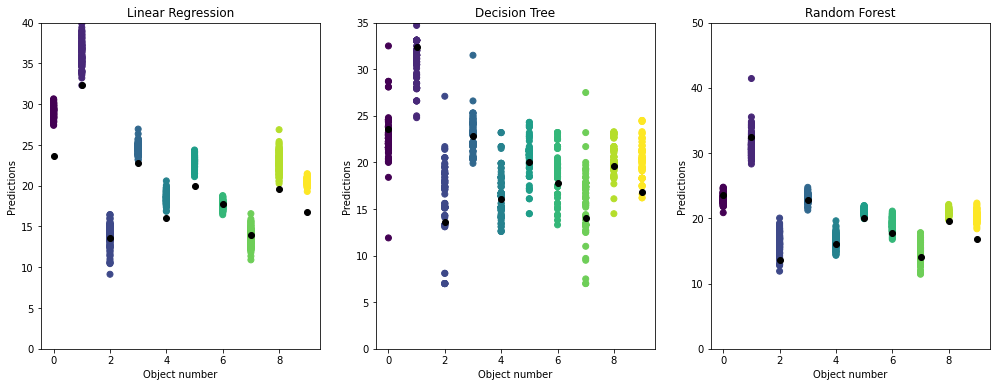

In [27]:
import random
plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, num_runs=100, title="Linear Regression")
plt.ylim((0, 40))
plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, num_runs=100, title="Decision Tree")
plt.ylim((0, 35))
plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, num_runs=100, title="Random Forest")
plt.ylim((0, 50))

__6. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
1) Маленький разброс, большошое смещение
2) Большой разброс, большое смещение
3) Маленький разброс, небольшое смещение

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

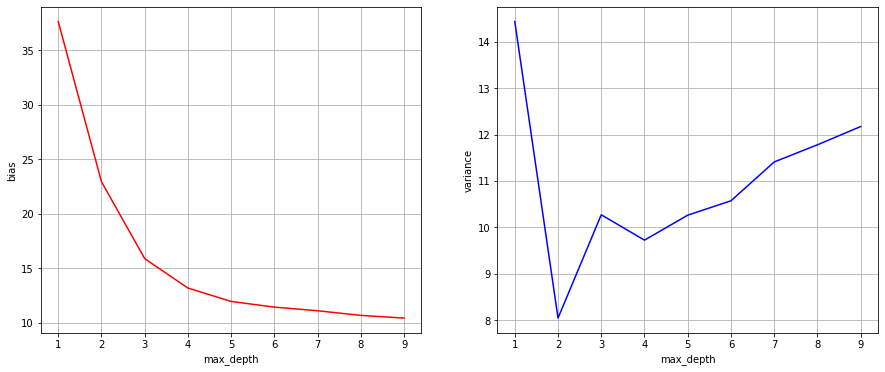

In [61]:
mx_depth = range(1, 10)


plt.figure(figsize=(15, 6))

biases = list()
variances = list()

for depth in mx_depth:
    regressor = DecisionTreeRegressor(max_depth=depth)
    bias, variance, _ = compute_biase_variance(regressor, X, y, num_runs=400)
    biases.append(bias)
    variances.append(variance)

plt.subplot2grid((1, 2), (0, 0))
plt.plot(mx_depth, np.array(biases), '-', c='r')
plt.xlabel("max_depth")
plt.ylabel("bias")
plt.grid(True)
plt.subplot2grid((1, 2), (0, 1))
plt.plot(mx_depth, np.array(variances), '-', c='b')
plt.xlabel("max_depth")
plt.ylabel("variance")
plt.grid(True)
plt.show()

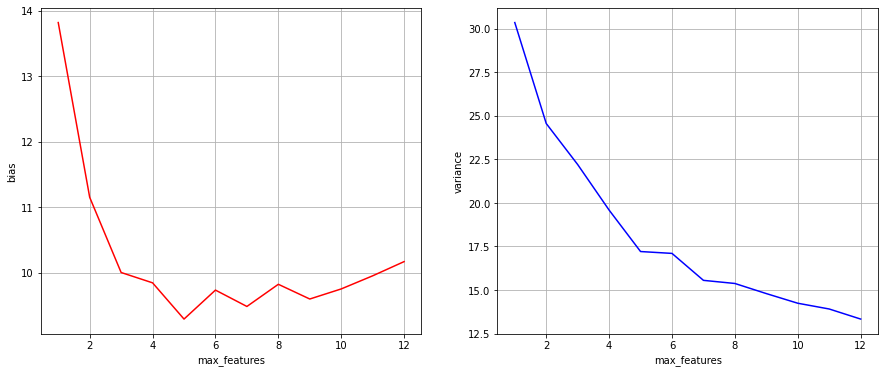

In [66]:
mx_features = range(1, X.shape[1])
plt.figure(figsize=(15, 6))

biases = list()
variances = list()

for feature in mx_features:
    regressor = DecisionTreeRegressor(max_features=feature)
    bias, variance, _ = compute_biase_variance(regressor, X, y, num_runs=400)
    biases.append(bias)
    variances.append(variance)

plt.subplot2grid((1, 2), (0, 0))
plt.plot(mx_features, np.array(biases), '-', c='r')
plt.xlabel("max_features")
plt.ylabel("bias")
plt.grid(True)
plt.subplot2grid((1, 2), (0, 1))
plt.plot(mx_features, np.array(variances), '-', c='b')
plt.xlabel("max_features")
plt.ylabel("variance")
plt.grid(True)
plt.show()

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

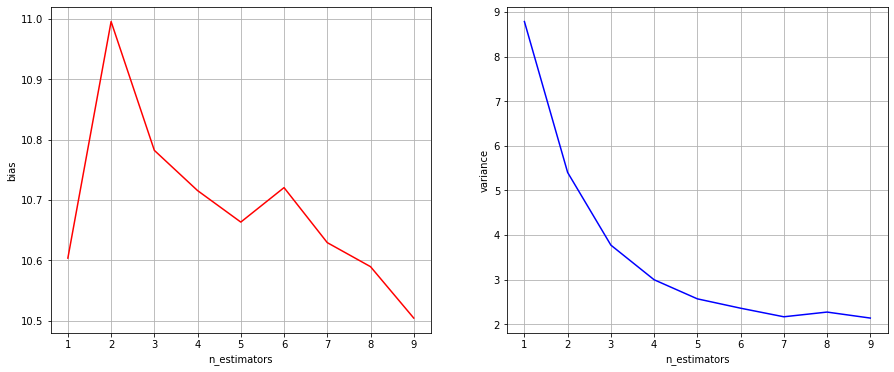

In [64]:
mx_est = range(1, 10)
n = 2**np.arange(1, 10)

plt.figure(figsize=(15, 6))

biases = list()
variances = list()

for est in mx_est:
    regressor = RandomForestRegressor(n_estimators=n[est-1])
    bias, variance, _ = compute_biase_variance(regressor, X, y, num_runs=400)
    biases.append(bias)
    variances.append(variance)

plt.subplot2grid((1, 2), (0, 0))
plt.plot(mx_est, np.array(biases), '-', c='r')
plt.xlabel("n_estimators")
plt.ylabel("bias")
plt.grid(True)
plt.subplot2grid((1, 2), (0, 1))
plt.plot(mx_est, np.array(variances), '-', c='b')
plt.xlabel("n_estimators")
plt.ylabel("variance")
plt.grid(True)
plt.show()



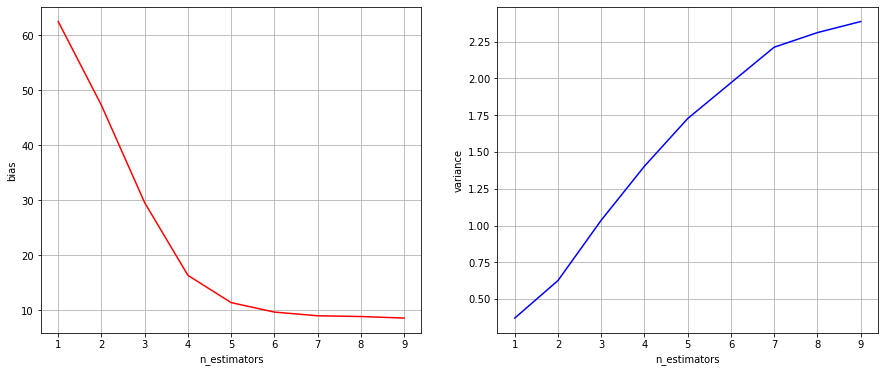

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
mx_est = range(1, 10)
n = 2**np.arange(1, 10)

plt.figure(figsize=(15, 6))

biases = list()
variances = list()

for est in mx_est:
    regressor = GradientBoostingRegressor(n_estimators=n[est-1])
    bias, variance, _ = compute_biase_variance(regressor, X, y, num_runs=400)
    biases.append(bias)
    variances.append(variance)

plt.subplot2grid((1, 2), (0, 0))
plt.plot(mx_est, np.array(biases), '-', c='r')
plt.xlabel("n_estimators")
plt.ylabel("bias")
plt.grid(True)
plt.subplot2grid((1, 2), (0, 1))
plt.plot(mx_est, np.array(variances), '-', c='b')
plt.xlabel("n_estimators")
plt.ylabel("variance")
plt.grid(True)
plt.show()

__3. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

1) При большей глубине, уменьшается и смещение
2) Чем больше глубина, тем больше и разброс. Оптимальное значение получается при глубине 2
3) Чем меньше число n_estimator, тем больше смещение
4) При большем значении n_estimator, уменьшается и смещение

__Вывод__

Таким образом, можно сделать вывод, что 
1. Наименьший разброс достигается в оптимальном значении - 2, что совпадает со значениями смещения, которые зависят от от глубины.
2. Если обратить внимание на случайные признаки, то разброс зависит от увеличения данных признаков, а смещение достигается оптимального значения при количественном состоянии признаков, равном 5.
3. Количество оценщиков в случаном лесу в основном влияют на разброс, что говорит о зависимости увеличения оценщиков на уменьшение разброса. Такая же зависимость у смещения, которое аналогично разбросу уменьшается при увеличении оценщиков.
4. В градиентном бустинге оценщик аналогично влияет на смещение, но в противоположною сторону влияет на разброс.